# <center>Multi-task U-Net</center>

The present notebook aims to implement a Unet-based architecture to segment veins, arms, and background. At the same time, it detects the antecubital fossa region and the arm orientation.

## 1. Downloading the data

In [ ]:
# !pip install tf2onnx

import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm
import warnings
import pandas as pd
import time
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Input, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.utils import load_img, img_to_array, plot_model
from tensorflow.keras import backend as K

from google.colab import drive, files

from skimage.metrics import peak_signal_noise_ratio
from scipy.spatial import distance
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import jaccard_score, accuracy_score, f1_score

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
print(tf.__version__)

!python --version

2.14.0
Python 3.10.12


In [ ]:
LOCAL_DATASET_PATH = "/content/dataset"
if os.path.exists(LOCAL_DATASET_PATH):
  shutil.rmtree(LOCAL_DATASET_PATH)

# Download the dataset
!unzip -qn "$GDRIVE_DATASET_PATH" -d "$LOCAL_DATASET_PATH" > /dev/null

for folder in glob(LOCAL_DATASET_PATH+"/*"):
  for in_folder in glob(folder+"/*"):
    file_name = in_folder.split("/")[4]
    shutil.move(in_folder,os.path.join(LOCAL_DATASET_PATH, file_name))

  shutil.rmtree(folder)

In [ ]:
dataset = pd.read_csv(os.path.join(LOCAL_DATASET_PATH, "dataset.csv"))

dataset

,id,person_id,age,complexion,genere,observation,nir_image,preprocessed_image,mask,acf_bbox_x1,acf_bbox_x2,acf_bbox_y1,acf_bbox_y2,acf_center_x,acf_center_y,arm_angle
0,0,M0658,12,slim,M,NaN,nir_images/655_aug232638114510.png,preprocessed_images/655_aug232637918084.png,masks/655_aug232638114510.png,255,285,205,236,270,220,89.0
1,1,M0667,11,slim,F,NaN,nir_images/1672_aug232638968332.png,preprocessed_images/1672_aug232638714878.png,masks/1672_aug232638968332.png,250,271,243,264,260,253,117.0
2,2,M0057,10,slim,F,NaN,nir_images/56_aug232639991764.png,preprocessed_images/56_aug232639634073.png,masks/56_aug232639991764.png,265,317,280,331,291,305,164.0
3,3,M0912,6,slim,F,NaN,nir_images/1917_aug232641082855.png,preprocessed_images/1917_aug232640793377.png,masks/1917_aug232641082855.png,245,276,217,248,260,232,63.0
4,4,M0586,16,slim,M,NaN,nir_images/1591_aug232642043543.png,preprocessed_images/1591_aug232641747597.png,masks/1591_aug232642043543.png,260,300,215,256,280,235,87.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7988,7988,M1006,16,slim,F,NaN,nir_images/2011.png,preprocessed_images/2011.png,masks/2011.png,233,285,192,243,259,217,177.0
7989,7989,M1007,19,slim,M,NaN,nir_images/2012.png,preprocessed_images/2012.png,masks/2012.png,174,231,227,286,202,256,11.0
7990,7990,M1008,16,slim,M,NaN,nir_images/2013.png,preprocessed_images/2013.png,masks/2013.png,191,259,166,240,225,203,5.0
7991,7991,M1009,16,slim,F,NaN,nir_images/2014.png,preprocessed_images/2014.png,masks/2014.png,226,291,175,235,258,205,5.0


Check that all files exist

In [ ]:
for idx, sample in dataset.iterrows():
  if not os.path.exists(os.path.join(LOCAL_DATASET_PATH, sample["preprocessed_image"])):
    print(os.path.exists(os.path.joinLOCAL_DATASET_PATH, sample["preprocessed_image"]), "doesn't exist!")
  if not os.path.exists(os.path.join(LOCAL_DATASET_PATH, sample["mask"])):
    print(os.path.exists(os.path.joinLOCAL_DATASET_PATH, sample["mask"]), "doesn't exist!")
  if not os.path.exists(os.path.join(LOCAL_DATASET_PATH, sample["nir_image"])):
    print(os.path.exists(os.path.joinLOCAL_DATASET_PATH, sample["nir_image"]), "doesn't exist!")

print("Dataset size:",len(dataset))
print("Masks",len(glob("/content/dataset/masks/*.png")))
print("Preprocessed images",len(glob("/content/dataset/preprocessed_images/*.png")))
print("NIR images",len(glob("/content/dataset/nir_images/*.png")))

Dataset size: 7993
Masks 7993
Preprocessed images 7993
NIR images 7993


## 2. Creating a TensorFlow Dataset

In [ ]:
IMAGE_SIZE = 512
BATCH_SIZE = 16
NUM_CLASSES = 3
MULTITASK = True

TOTAL_SAMPLES = len(dataset)
print("Total samples:", TOTAL_SAMPLES)

NUM_TRAIN_SAMPLES = int(TOTAL_SAMPLES * 0.70)
NUM_VAL_SAMPLES = int(TOTAL_SAMPLES * 0.20)
NUM_TEST_SAMPLES = int(TOTAL_SAMPLES * 0.10)

print("Number of train images:",NUM_TRAIN_SAMPLES," val images:",NUM_VAL_SAMPLES," test images:",NUM_TEST_SAMPLES)

def obtain_subset(dataset):
  images = [os.path.join(LOCAL_DATASET_PATH, image) for image in dataset["preprocessed_image"].values]
  masks = [os.path.join(LOCAL_DATASET_PATH, image) for image in dataset["mask"].values]
  x_centers = [ int(x) for x in dataset["acf_center_x"].values]
  y_centers = [ int(y) for y in dataset["acf_center_y"].values]
  angles = [ int(angle) for angle in dataset["arm_angle"].values]
  if MULTITASK:
    return images, masks, x_centers, y_centers, angles
  else:
    return images, masks

def read_image(image_path, mask=False):
  image = tf.io.read_file(image_path)
  if mask:
    image = tf.image.decode_png(image, channels=1)
    image.set_shape([None, None, 1])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, dtype=tf.int32, name = 'mask')
  else:
    image = tf.image.decode_png(image, channels=1)
    image.set_shape([None, None, 1])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE], name="image")
    image = image / 127.5 - 1
  return image

# Data loaders for normal image segmentation
def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

# Data loaders for multitask
def load_data_multitask(image, mask, x, y, angle):
  image = read_image(image)
  mask = read_image(mask, mask=True)
  x = x/IMAGE_SIZE
  y = y/IMAGE_SIZE
  values = tf.convert_to_tensor([x, y], dtype=tf.float32, name="values")
  return image, mask, values

def data_generator_multitask(images, masks, acf_x_centers, acf_y_centers, angles):
  dataset = tf.data.Dataset.from_tensor_slices((images, masks, acf_x_centers, acf_y_centers, angles))
  dataset = dataset.map(load_data_multitask, num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  return dataset

if MULTITASK:
  train_images, train_masks, train_acf_x_centers, train_acf_y_centers, train_angles = obtain_subset(dataset[:NUM_TRAIN_SAMPLES])
  val_images, val_masks, val_acf_x_centers, val_acf_y_centers, val_angles = obtain_subset(dataset[NUM_TRAIN_SAMPLES : NUM_VAL_SAMPLES + NUM_TRAIN_SAMPLES])
  test_images, test_masks, test_acf_x_centers, test_acf_y_centers, test_angles = obtain_subset(dataset[NUM_VAL_SAMPLES + NUM_TRAIN_SAMPLES : ])

  train_dataset = data_generator_multitask(train_images, train_masks, train_acf_x_centers, train_acf_y_centers, train_angles)
  val_dataset = data_generator_multitask(val_images, val_masks, val_acf_x_centers, val_acf_y_centers, val_angles)
  test_dataset = data_generator_multitask(test_images, test_masks, test_acf_x_centers, test_acf_y_centers, test_angles)
else:
  train_images, train_masks = obtain_subset(dataset[:NUM_TRAIN_SAMPLES])
  val_images, val_masks = obtain_subset(dataset[NUM_TRAIN_SAMPLES : NUM_VAL_SAMPLES + NUM_TRAIN_SAMPLES])
  test_images, test_masks = obtain_subset(dataset[NUM_VAL_SAMPLES + NUM_TRAIN_SAMPLES : ])

  train_dataset = data_generator(train_images, train_masks)
  val_dataset = data_generator(val_images, val_masks)
  test_dataset = data_generator(test_images, test_masks)

print("Train subset has n batches:", len(train_dataset), "- Data type:", train_dataset)
print("Val subset has n batches:", len(val_dataset), "- Data type:", val_dataset)
print("Test subset has n batches:", len(test_dataset), "- Data type:", test_dataset)

Total samples: 7993
Number of train images: 5595  val images: 1598  test images: 799
Train subset has n batches: 349 - Data type: <_BatchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.int32, name=None), TensorSpec(shape=(16, 2), dtype=tf.float32, name=None))>
Val subset has n batches: 99 - Data type: <_BatchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.int32, name=None), TensorSpec(shape=(16, 2), dtype=tf.float32, name=None))>
Test subset has n batches: 50 - Data type: <_BatchDataset element_spec=(TensorSpec(shape=(16, 512, 512, 1), dtype=tf.float32, name=None), TensorSpec(shape=(16, 512, 512, 1), dtype=tf.int32, name=None), TensorSpec(shape=(16, 2), dtype=tf.float32, name=None))>


Visualize a random sample from the dataset

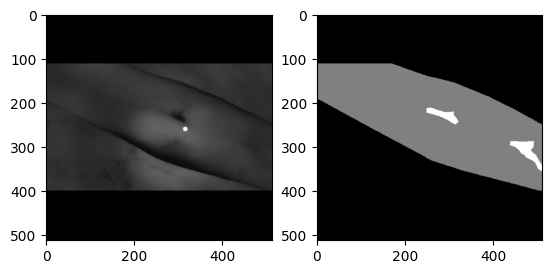

In [ ]:
def show_random_sample(subset):

  random_batch = random.randint(0, len(subset))
  for idx, batch in enumerate(subset):
    if idx == random_batch:
      images = batch[0]
      masks = batch[1]
      values = batch[2]

      random_sample = random.randint(0, len(images)-1)
      image = np.squeeze(images[random_sample].numpy())
      mask = np.squeeze(masks[random_sample].numpy())
      x = int(values[random_sample].numpy()[0]*IMAGE_SIZE)
      y = int(values[random_sample].numpy()[1]*IMAGE_SIZE)
      # angle = int(values[random_sample].numpy()[2])

      image = cv2.circle(image, (x,y), radius=5, color=4, thickness=-1)
      # print("Angle:",angle)

      fif = plt.figure()
      fif.add_subplot(1,2, 1)
      plt.imshow(image, cmap="gray")
      fif.add_subplot(1,2, 2)
      plt.imshow(mask, cmap="gray")
      plt.show(block=True)
      break

show_random_sample(train_dataset)

## 3. Model development

### 3.1 Train model

In [ ]:
class CustomModel(tf.keras.Model):
  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
    self.avg_loss_training = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
    self.avg_loss_validation = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)
    # self.mae_metric = keras.metrics.MeanAbsoluteError(name="mae", dtype=tf.float32)
    # self.mae_metric = keras.metrics.MeanAbsoluteError(name="mse", dtype=tf.float32)

  def train_step(self, data):
    images, masks, values = data
    with tf.GradientTape() as tape:
      outputs = self(images, training=True) # forward pass
      # segmentation loss
      crossentropy_loss = tf.keras.losses.sparse_categorical_crossentropy(masks, outputs[0])
      # regression loss
      regression_loss = tf.reduce_sum(tf.keras.losses.mean_squared_error(values, outputs[1]))
      total_loss = crossentropy_loss + regression_loss

    # Compute gradients
    gradients = tape.gradient(total_loss, self.trainable_variables)
    # Update weights
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    # Update metrics (includes the metric that tracks the loss)
    self.avg_loss_training.update_state(total_loss)
    return {"train_loss": self.avg_loss_training.result()}

  def test_step(self, data):
    # Unpack the data
    images, masks, values = data
    # Compute predictions
    outputs = self(images, training=False)
    # Updates the metrics tracking the loss
    # segmentation loss
    crossentropy_loss = tf.keras.losses.sparse_categorical_crossentropy(masks, outputs[0])
    # regression loss
    regression_loss = tf.reduce_sum(tf.keras.losses.mean_squared_error(values, outputs[1]))
    total_loss = crossentropy_loss + regression_loss
    # Update metrics (includes the metric that tracks the loss)
    self.avg_loss_validation.update_state(total_loss)
    # Return a dict mapping metric names to current value.
    # Note that it will include the loss (tracked in self.metrics).
    return {"loss": self.avg_loss_validation.result()}

  @property
  def metrics(self):
    # We list our `Metric` objects here so that `reset_states()` can be
    # called automatically at the start of each epoch
    # or at the start of `evaluate()`.
    # If you don't implement this property, you have to call
    # `reset_states()` yourself at the time of your choosing.
    return [self.avg_loss_training, self.avg_loss_validation]

def define_unet(img_size, num_classes, multitask=False):
  inputs = keras.Input(shape=img_size + (1,))

  ### [First half of the network: downsampling inputs] ###

  # Entry block
  x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x  # Set aside residual

  embeddings = None

  # Blocks 1, 2, 3 are identical apart from the feature depth.
  for filters in [64, 128, 256, 512]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

    if filters == 512:
      embeddings = x

  ### [Second half of the network: upsampling inputs] ###

  for filters in [512, 256, 128, 64, 32]:
    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.UpSampling2D(2)(x)

    # Project residual
    residual = layers.UpSampling2D(2)(previous_block_activation)
    residual = layers.Conv2D(filters, 1, padding="same")(residual)
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

  ### [Neural Network] ###
  y = layers.Flatten()(embeddings)
  y = layers.Dense(128, activation='sigmoid')(y)
  y = layers.Dense(128, activation='sigmoid')(y)
  y = layers.Dense(64, activation='sigmoid')(y)
  output_regression = layers.Dense(2, activation='sigmoid', name='task_2_output')(y)

  # Add a per-pixel classification layer
  output_segmentation = layers.Conv2D(num_classes, 3, activation="softmax", padding="same", name='task_1_output')(x)

  # Define the model
  if multitask:
    model = CustomModel(inputs, outputs=[output_segmentation, output_regression])
  else:
    model = keras.Model(inputs, output_segmentation)
  return model

keras.backend.clear_session()
unet = define_unet((IMAGE_SIZE,IMAGE_SIZE), NUM_CLASSES, multitask=MULTITASK)

EPOCHS = 20
if MULTITASK:
  optimizer = keras.optimizers.Adam(learning_rate=0.01)
  unet.compile(optimizer=optimizer,
               weighted_metrics=[])

  start = time.time()
  history = unet.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=EPOCHS,
                    verbose=1,
                    )
  print(f'Training time: {time.time() - start}\n')
else:
  unet.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])
  history = unet.fit(train_dataset, epochs=EPOCHS, validation_data=val_dataset, verbose=1)

In [ ]:
def show_metrics(history):
  fig, ax = plt.subplots(1, 2, figsize=(12, 3))
  ax = ax.ravel()

  for i, metric in enumerate(["train_loss", "val_loss"]): # TODO: Include types of loss and metrics
      ax[i].plot(history.history[metric])
      # ax[i].plot(history.history["val_" + metric])
      ax[i].set_title("Model {}".format(metric))
      ax[i].set_xlabel("epochs")
      ax[i].set_ylabel(metric)
      ax[i].legend(["train", "val"])

show_metrics(history)

Test detections

In [ ]:
def infer(model, image_tensor):
  '''
    Make inferences using a model and a new image. The latter requires to be in a Tensor format
  '''
  mask, values = model.predict(np.expand_dims((image_tensor), axis=0), verbose=0)
  mask = np.squeeze(mask)
  mask = np.argmax(mask, axis=2).astype(np.uint8)

  values = np.squeeze(values)
  x = int(values[0]*IMAGE_SIZE)
  y = int(values[1]*IMAGE_SIZE)
  return mask, x, y

def show_prediction(image_file, mask_file, x_center, y_center, angle, model):

  # Read an image and its corresponding mask
  image_tensor = read_image(image_file)
  mask_tensor = read_image(mask_file, mask=True)
  image_npy = image_tensor.numpy()* 127.5 + 1
  mask_npy = np.squeeze(mask_tensor.numpy()).astype(np.uint8)

  # Make use of the model to predict a mask with a new image. Returns a numpy array.
  predicted_mask, predicted_x, predicted_y = infer(model=model, image_tensor=image_tensor)
  mask_npy = cv2.circle(mask_npy, (x_center, y_center), radius=5, color=4, thickness=-1)
  predicted_mask = cv2.circle(predicted_mask, (predicted_x, predicted_y), radius=5, color=4, thickness=-1)

  # Make use of the model to predict a mask with a new image. Returns a numpy array.
  fif = plt.figure()
  fif.add_subplot(1,2, 1)
  plt.title("Real")
  plt.imshow(image_npy, cmap="gray")
  plt.imshow(mask_npy, cmap="winter", alpha=0.5)
  fif.add_subplot(1,2, 2)
  plt.title("Predicted")
  plt.imshow(image_npy, cmap="gray")
  plt.imshow(predicted_mask, cmap="winter", alpha=0.5)
  plt.show(block=True)

random_sample = random.randint(0, len(test_images)-1)
image = test_images[random_sample]
mask = test_masks[random_sample]
x_center = test_acf_x_centers[random_sample]
y_center = test_acf_y_centers[random_sample]
angle = test_angles[random_sample]

show_prediction(image, mask, x_center, y_center, angle, unet)

### 3.2 Test model

In [ ]:
def infer(model, image_tensor):
  '''
    Make inferences using a model and a new image. The latter requires to be in a Tensor format
  '''
  predictions = model.predict(np.expand_dims((image_tensor), axis=0), verbose=0)
  predictions = np.squeeze(predictions[0])
  predictions = np.argmax(predictions, axis=2)
  return predictions

def find_metrics(images_list, masks_list, x_centers_list, y_centers_list, angles, model):
  '''
    This function gets metrics for a model according to the groundtruth
  '''
  ious = []
  dices = []
  psnrs = []
  accuracys = []
  f1scores = []

  for image_file, mask_file in tqdm(zip(images_list, masks_list),total=len(images_list)):
    # Read an image and its corresponding mask
    image_tensor = read_image(image_file)
    mask_tensor = read_image(mask_file, mask=True)
    # Make use of the model to predict a mask with a new image. Returns a numpy array.
    prediction_mask = infer(image_tensor=image_tensor, model=model)

    actual = np.squeeze(mask_tensor.numpy()).astype(np.uint8).flatten()
    predicted = prediction_mask.astype(np.uint8).flatten()

    ious.append(jaccard_score(actual, predicted, average="weighted"))
    dices.append(distance.dice(actual, predicted))
    psnrs.append(peak_signal_noise_ratio(actual, predicted))
    accuracys.append(accuracy_score(actual, predicted))
    f1scores.append(f1_score(actual, predicted, average="weighted"))

  return [np.mean(ious),
          np.mean(dices),
          np.mean(psnrs),
          np.mean(accuracys),
          np.mean(f1scores)]

total_samples = 100
# total_samples = len(test_images)
metrics = find_metrics(images_list=test_images[:total_samples],
                       masks_list=test_masks[:total_samples],
                       x_centers_list=test_acf_x_centers[:total_samples],
                       y_centers_list=test_acf_y_centers[:total_samples],
                       angles=test_angles[:total_samples],
                       model=unet)
print("\n","IoU:",metrics[0],"Dice Score:",metrics[1],"PSNR:",metrics[2],"Accuracy:",metrics[3],"F1-Score:",metrics[4])

100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


 IoU: 0.8695174739781525 Dice Score: 0.6142422035348774 PSNR: 58.62306010613107 Accuracy: 0.9136306381225586 F1-Score: 0.915447019202371


### 3.3 Save model

In [ ]:
def save_model(model, model_name):
  model_folder_path = os.path.join(EXPERIMENTS_PATH, model_name)
  if not os.path.exists(model_folder_path):
    os.mkdir(model_folder_path)
  model.save(os.path.join(model_folder_path,"best_model"))

save_model(unet, "unet")

## 5. Model compression

In [ ]:
for model, model_name in zip([pspnet],["pspnet"]):
  # Model compression with TFLite
  converter = tf.lite.TFLiteConverter.from_saved_model(EXPERIMENTS_PATH+model_name+"/best_model")
  converter.target_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                          tf.lite.OpsSet.SELECT_TF_OPS]

  try:
    tflite_model = converter.convert()
  except:
    print(model_name+" caused errors when compressing.")
  if not os.path.exists(EXPERIMENTS_PATH+model_name+"/compressed_model"):
    os.mkdir(EXPERIMENTS_PATH+model_name+"/compressed_model")
  open(EXPERIMENTS_PATH+model_name+"/compressed_model/model.tflite", "wb").write(tflite_model)